# tf_tutorial_quick_start_by_mnist_use_custom_model
- ref: https://www.tensorflow.org/tutorials/quickstart/advanced?hl=ja

In [3]:
import tensorflow as tf
import tensorflow.keras.layers as layers

## prepare dataset

- 8bit整数のnumpy.arrayが返ってくる。

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(type(x_train), x_train.dtype)
print(type(y_train), y_train.dtype)

<class 'numpy.ndarray'> uint8
<class 'numpy.ndarray'> uint8


- 8bitの最大値(255)で正規化して0～1にする。
- モノラルなのでチャンネル次元がない。チャンネル次元を追加する。
- model内でconvを使うからだと思われる。

In [12]:
# normalize
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

- datasetクラスに変換

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

## define model

In [19]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, activation='relu')
        self.flatten = layers.Flatten()
        self.d1 = layers.Dense(128, activation='relu')
        self.d2 = layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

In [ ]:
model = MyModel()

- カスタムの場合、可視化が難しい？？

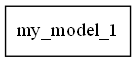

In [37]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=100)

## losses and metrics

- `tf.keras.metrics.Mean`などでロスを累積できるのはTIPSだな。

In [22]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

## update step function

- decolatorでこういう風にするのか

In [23]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

## training sequence

In [26]:
EPOCHS = 5

for epoch in range(EPOCHS):

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    print(f'Epoch {epoch+1}, ', end="")
    print(f'Loss: {train_loss.result():.3f}, ', end="")
    print(f'Accuracy: {train_accuracy.result()*100:.3f}, ', end="")
    print(f'Test Loss: {test_loss.result():.3f}, ', end="")
    print(f'Test Accuracy: {test_accuracy.result()*100:.3f}')

    # clear metrics
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

Epoch 1, Loss: 0.005, Accuracy: 99.848, Test Loss: 0.087, Test Accuracy: 98.360
Epoch 2, Loss: 0.002, Accuracy: 99.925, Test Loss: 0.090, Test Accuracy: 98.480
Epoch 3, Loss: 0.004, Accuracy: 99.885, Test Loss: 0.109, Test Accuracy: 98.130
Epoch 4, Loss: 0.003, Accuracy: 99.903, Test Loss: 0.101, Test Accuracy: 98.370
Epoch 5, Loss: 0.002, Accuracy: 99.925, Test Loss: 0.090, Test Accuracy: 98.450


In [1]:
# 以上